<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/TableBank_Detectron2_Table_Detection_In_Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TableBank

Link: https://github.com/doc-analysis/TableBank

TableBank is a new image-based table detection and recognition dataset built with novel weak supervision from Word and Latex documents on the internet, contains 417K high-quality labeled tables.

We use the open-source framework Detectron2 [Wu et al., 2019] to train models on the TableBank.

In this notebook, we include the instructions to predict tables in documents using some of the availabel trained models. 

## Installation

In [ ]:
# install dependencies: 
!pip install "pyyaml==5.1" "pycocotools>=2.0.1"
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

## Imports

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Load model files

The models trained using the TableBank dataset are available from: https://github.com/doc-analysis/TableBank/blob/master/MODEL_ZOO.md

To use one of these models, I downloaded it and uploaded the files to my own drive. 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initially, the model files are:

 - `model_final.pth`: Model weights
 - `All_X101.yaml`: Configuration of the model

In [21]:
!ls /content/drive/MyDrive | grep '\.pth$' 

model_final.pth


In [20]:
!ls /content/drive/MyDrive | grep '\.yaml$' 

All_X101.yaml
Base-RCNN-FPN.yaml


The configuration file uses an internal detectron2 Base conf file (`Base-RCNN-FPN.yaml`). I include it in my drive too, and I modified the route to it (param `__BASE__`).

In [22]:
!cat /content/drive/MyDrive/All_X101.yaml

_BASE_: "/content/drive/MyDrive/Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl"
  MASK_ON: False
  PIXEL_STD: [57.375, 57.120, 58.395]
  RESNETS:
    STRIDE_IN_1X1: False 
    NUM_GROUPS: 32
    WIDTH_PER_GROUP: 8
    DEPTH: 101
  ROI_HEADS:
    NUM_CLASSES: 1
SOLVER:
  STEPS: (88000, 99000)
  MAX_ITER: 110000
  IMS_PER_BATCH: 24
  BASE_LR: 0.03
DATASETS:
  TRAIN: ("tablebank_word_train", "tablebank_latex_train")
  TEST: ("tablebank_word_val", "tablebank_latex_val")
DATALOADER:
  NUM_WORKERS: 2
OUTPUT_DIR: "output/X101/All_X101"


## Load predictor

In [6]:
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/All_X101.yaml")
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/model_final.pth") 
predictor = DefaultPredictor(cfg)

## Load input image

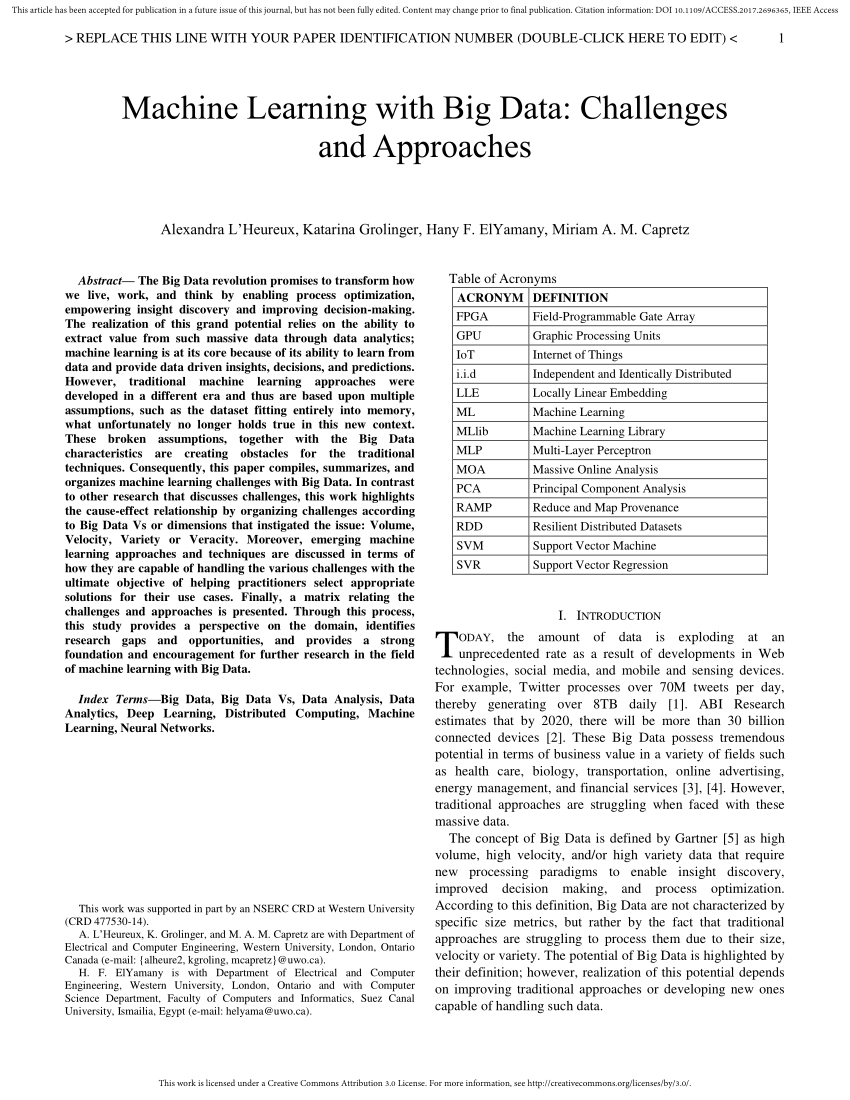

In [7]:
!wget https://i1.rgstatic.net/publication/316448042_Machine_Learning_With_Big_Data_Challenges_and_Approaches/links/5915a79d4585152e199f5b4f/largepreview.png -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

## Predict tables in document

In [8]:
outputs = predictor(im)

In [9]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0], device='cuda:0')
Boxes(tensor([[452.3112, 287.0310, 765.6723, 573.0518]], device='cuda:0'))


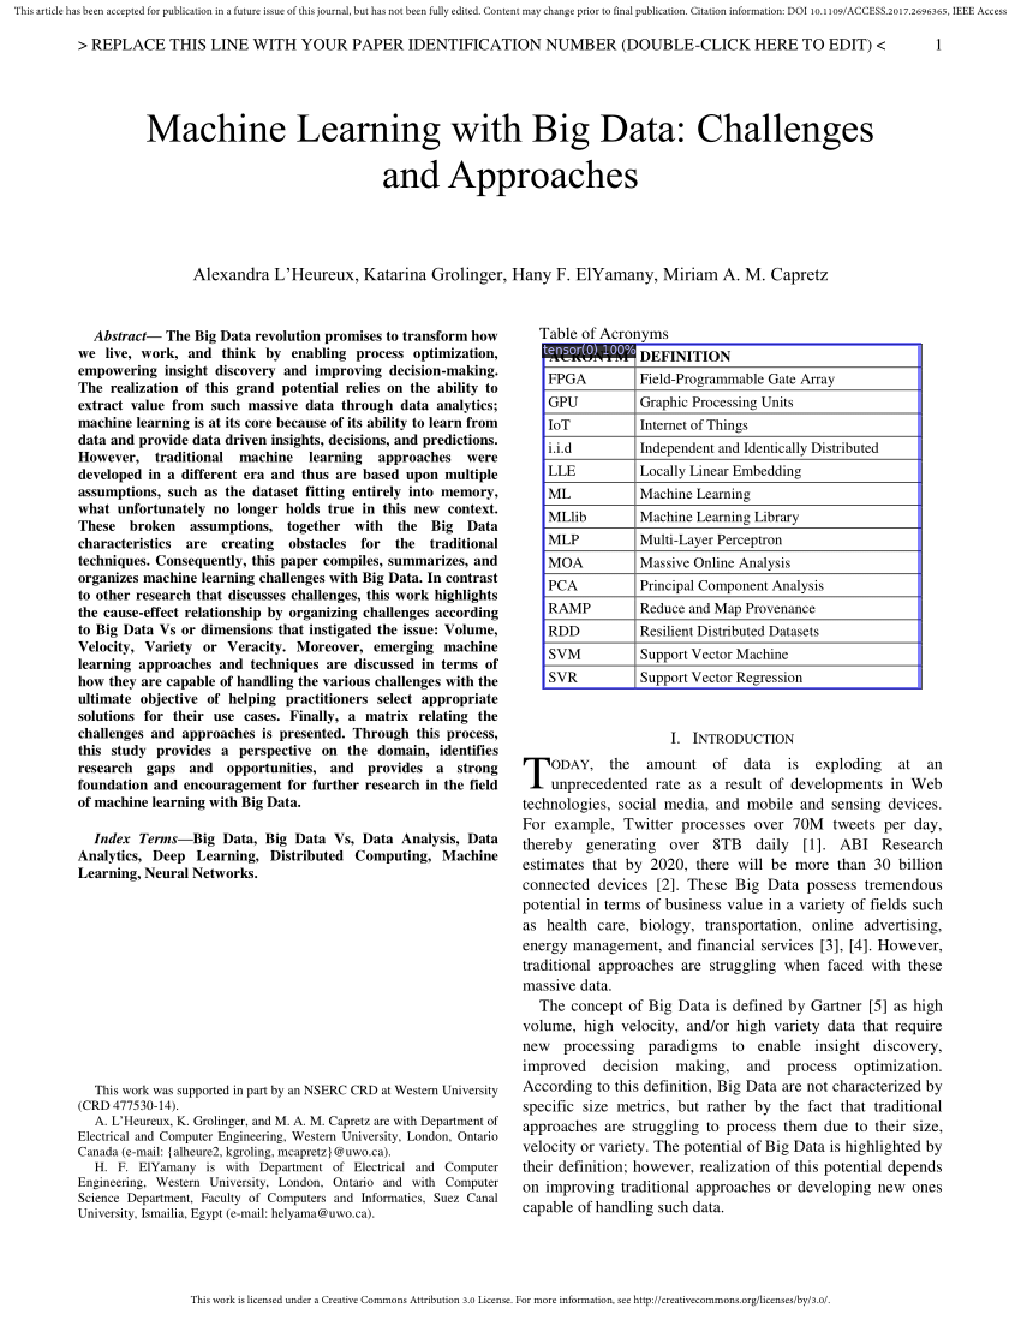

In [10]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])